In [1]:
%cd ../

/home/eli/AnacondaProjects/HTFATorch


In [2]:
import logging
import numpy as np
import re

import htfa_torch.dtfa as DTFA
import htfa_torch.niidb as niidb
import htfa_torch.utils as utils

In [3]:
%matplotlib inline

In [4]:
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %H:%M:%S',
                    level=logging.INFO)

In [5]:
lepping_db = niidb.FMriActivationsDb('data/sound_depression.db', mask='/home/eli/Documents/sound_depression/ds000171-download/all_tasks/wholebrain.nii.gz')

In [6]:
dtfa = DTFA.DeepTFA([b for b in lepping_db.all() if 'response' not in b.task and 'tones' not in b.task],
                    mask='/home/eli/Documents/sound_depression/ds000171-download/all_tasks/wholebrain.nii.gz', num_factors=100, embedding_dim=2)

06/10/2019 19:11:00 Loading Nifti image /home/eli/Documents/sound_depression/fmriprep/sub-control01/func/sub-control01_task-music_run-3_bold_space-MNI152NLin2009cAsym_preproc.nii.gz with mask /home/eli/Documents/sound_depression/ds000171-download/all_tasks/wholebrain.nii.gz (zscore=True, smooth=6)
06/10/2019 19:11:02 Loading Nifti image /home/eli/Documents/sound_depression/fmriprep/sub-control01/func/sub-control01_task-music_run-2_bold_space-MNI152NLin2009cAsym_preproc.nii.gz with mask /home/eli/Documents/sound_depression/ds000171-download/all_tasks/wholebrain.nii.gz (zscore=True, smooth=6)
06/10/2019 19:11:04 Loading Nifti image /home/eli/Documents/sound_depression/fmriprep/sub-control01/func/sub-control01_task-nonmusic_run-4_bold_space-MNI152NLin2009cAsym_preproc.nii.gz with mask /home/eli/Documents/sound_depression/ds000171-download/all_tasks/wholebrain.nii.gz (zscore=True, smooth=6)
06/10/2019 19:11:06 Loading Nifti image /home/eli/Documents/sound_depression/fmriprep/sub-control01/

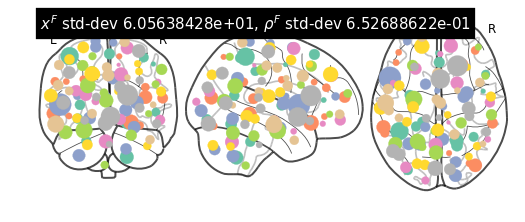

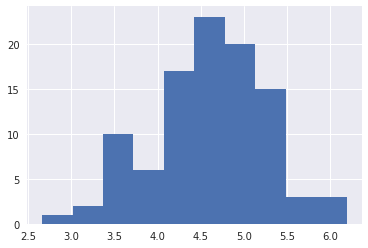

(<nilearn.plotting.displays.OrthoProjector at 0x7fe655f44b00>,
 tensor([[-3.1984e+01, -8.5575e+01, -9.5493e+00],
         [ 5.0053e+01,  1.5114e+01, -2.8354e+00],
         [-1.6062e-01,  3.7426e+01,  1.0618e+01],
         [-1.6945e+01, -3.4598e+01,  4.0862e+01],
         [ 1.9429e+01, -5.4449e+01, -4.9967e+01],
         [ 3.7341e+01, -5.0690e+01,  5.4835e+01],
         [-2.3204e+01, -3.9822e+01, -3.3292e+01],
         [ 1.1819e+00,  2.7642e+01,  5.8600e+01],
         [-2.9788e+01, -6.8171e+00,  4.9960e+00],
         [ 1.9850e+01, -5.6737e+01,  1.5306e+01],
         [ 1.9880e+01, -5.9914e+01, -1.4622e+01],
         [ 4.7423e+01, -2.6674e+00,  4.7906e+01],
         [-4.0674e+01, -4.4772e+01,  5.6234e+01],
         [ 1.1544e+01, -6.7842e+01,  5.6019e+01],
         [-2.6480e+01, -6.8433e+00,  3.2004e+01],
         [-4.1471e+01,  3.8182e+01, -6.7468e+00],
         [ 2.4707e+01,  5.9501e+01,  1.3795e+01],
         [ 3.9089e+01, -8.0704e+01,  1.2986e+01],
         [ 3.8961e+01,  4.0153e+01,  

In [7]:
dtfa.visualize_factor_embedding()

In [8]:
losses = dtfa.train(num_steps=1000, learning_rate={'q': 1e-2, 'p': 1e-4}, log_level=logging.INFO, num_particles=1,
                    batch_size=50, use_cuda=True, checkpoint_steps=100, blocks_batch_size=20, patience=100)

06/10/2019 19:17:18 [Epoch 1] (15359ms) Posterior free-energy 7.86185600e+08 = KL from prior 9.05549000e+05 - log-likelihood -7.85279936e+08
06/10/2019 19:17:18 Saving checkpoint...
06/10/2019 19:17:33 [Epoch 2] (15148ms) Posterior free-energy 7.61287488e+08 = KL from prior 8.71131375e+05 - log-likelihood -7.60416448e+08
06/10/2019 19:17:48 [Epoch 3] (14799ms) Posterior free-energy 7.43681408e+08 = KL from prior 8.33246875e+05 - log-likelihood -7.42848000e+08
06/10/2019 19:18:03 [Epoch 4] (14795ms) Posterior free-energy 7.28650624e+08 = KL from prior 8.03841562e+05 - log-likelihood -7.27846784e+08
06/10/2019 19:18:18 [Epoch 5] (14774ms) Posterior free-energy 7.16996992e+08 = KL from prior 7.80162125e+05 - log-likelihood -7.16216896e+08
06/10/2019 19:18:33 [Epoch 6] (14792ms) Posterior free-energy 7.07600064e+08 = KL from prior 7.56547812e+05 - log-likelihood -7.06843584e+08
06/10/2019 19:18:48 [Epoch 7] (14926ms) Posterior free-energy 6.98910912e+08 = KL from prior 7.39726125e+05 - log

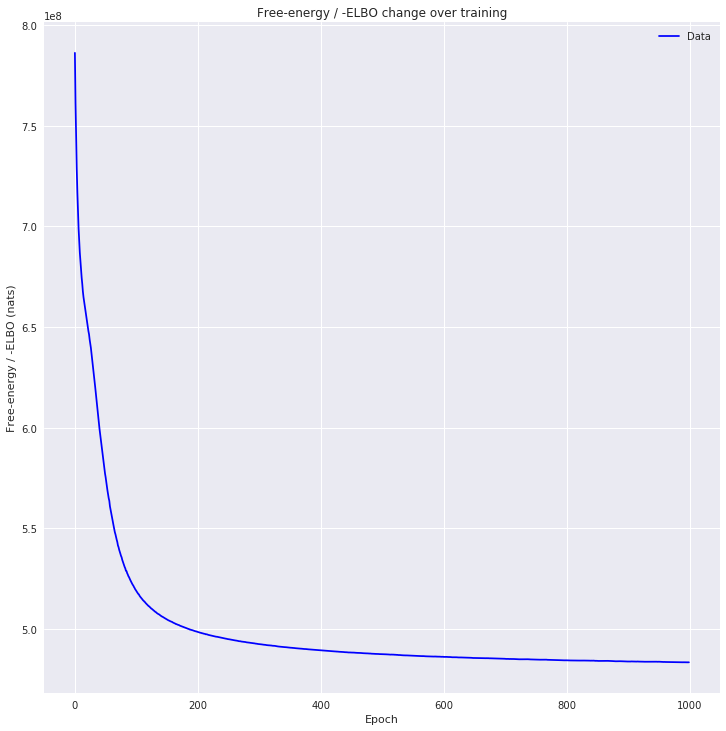

In [9]:
utils.plot_losses(losses)

In [15]:
def subject_labeler(subject):
    subject_regex = re.compile("([A-Za-z]+)([0-9]{1,2})")
    m = subject_regex.search(subject)
    condition, sub_num = m.groups()
    if condition == 'mdd':
        condition = 'Major Depressive'
    elif condition == 'control':
        condition = 'Control'
    return '%s Participant %d' % (condition, int(sub_num))

In [16]:
def task_labeler(task):
    if task == 'negative_music':
        task = 'Negative music'
    elif task == 'positive_music':
        task = 'Positive music'
    elif task == 'negative_nonmusic':
        task = 'Negative sounds'
    elif task == 'positive_nonmusic':
        task = 'Positive sounds'
    else:
        task = task.capitalize()
    return task

In [17]:
def lepping_2017_labeler(block):
    subject = subject_labeler(block.subject)
    task = task_labeler(block.subject)
    return subject + ', ' + task + ' stimulus'

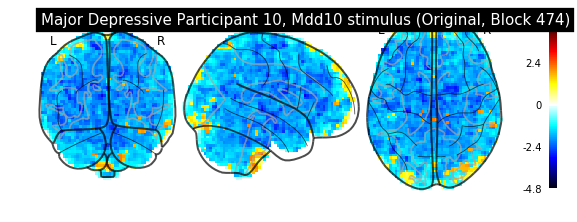

06/11/2019 16:21:55 Reconstruction Error (Frobenius Norm): 4.79861359e+02 out of 9.13259521e+02


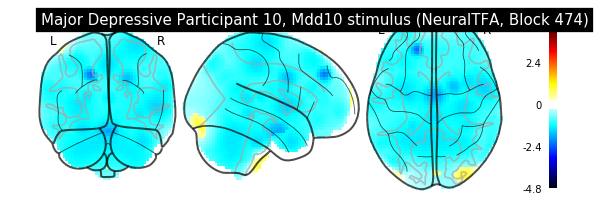

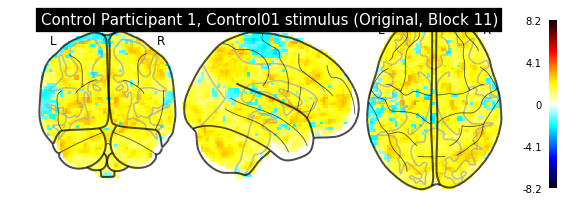

06/11/2019 16:21:58 Reconstruction Error (Frobenius Norm): 5.33218445e+02 out of 8.46233154e+02


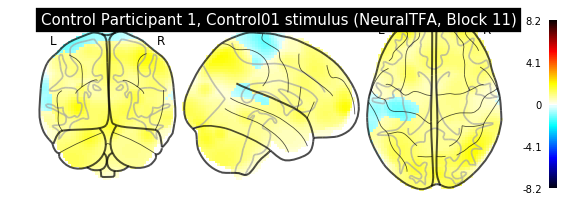

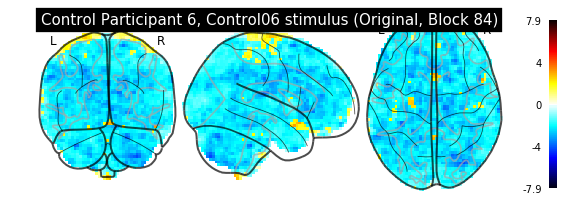

06/11/2019 16:22:01 Reconstruction Error (Frobenius Norm): 5.56751892e+02 out of 8.83896423e+02


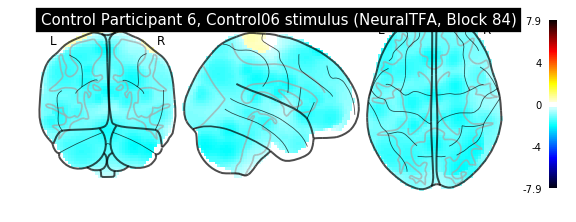

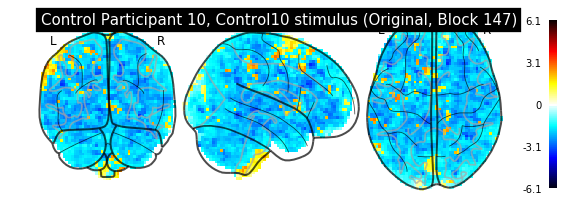

06/11/2019 16:22:04 Reconstruction Error (Frobenius Norm): 5.81876221e+02 out of 9.37894775e+02


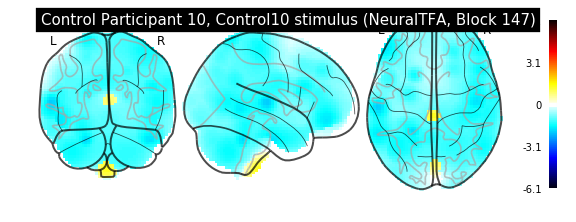

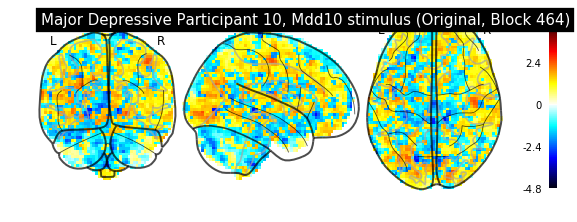

06/11/2019 16:22:07 Reconstruction Error (Frobenius Norm): 4.97816315e+02 out of 6.38944580e+02


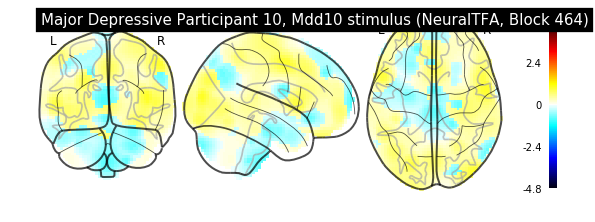

In [18]:
for b in np.random.choice(range(dtfa.num_blocks), 5):
    dtfa.plot_original_brain(b, labeler=lepping_2017_labeler)
    dtfa.plot_reconstruction(b, labeler=lepping_2017_labeler)

/home/eli/anaconda3/envs/HTFATorch/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


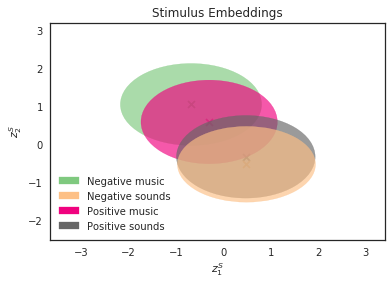

In [19]:
dtfa.scatter_task_embedding(labeler=task_labeler, figsize=None)

/home/eli/anaconda3/envs/HTFATorch/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


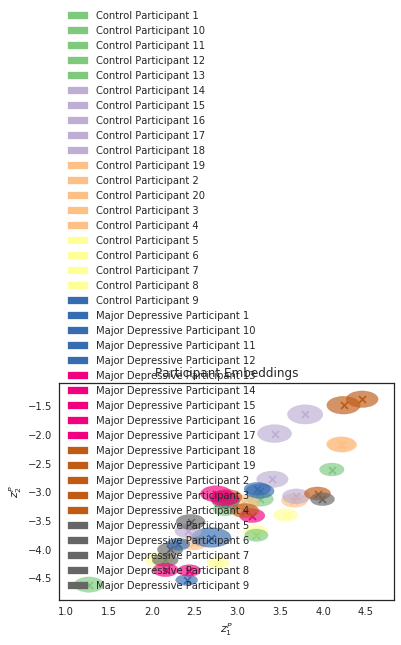

In [20]:
dtfa.scatter_subject_embedding(labeler=subject_labeler, figsize=None)

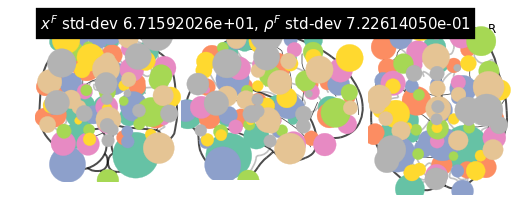

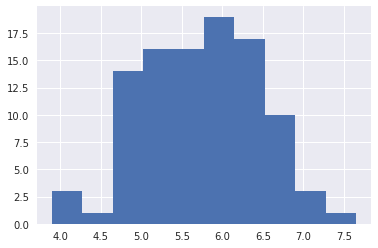

(<nilearn.plotting.displays.OrthoProjector at 0x7fe63869ada0>,
 tensor([[ -29.6677, -105.4942,   -4.3737],
         [  45.4463,    5.2009,   -9.8072],
         [  -3.7906,   43.5600,    2.6797],
         [ -27.4116,  -48.3278,   43.6158],
         [  28.8128,  -62.4595,  -48.0228],
         [  41.5903,  -64.0550,   60.6468],
         [ -33.8495,  -33.4702,  -27.6282],
         [   1.6703,   26.5728,   73.2798],
         [ -24.6969,  -12.2183,    5.3046],
         [  31.3879,  -48.9025,   21.5781],
         [  21.3056,  -64.4786,   -7.6440],
         [  39.8187,    2.2824,   53.7620],
         [ -52.5015,  -45.7789,   71.1636],
         [   3.8935,  -80.1655,   57.4276],
         [ -22.7703,  -12.9521,   45.3462],
         [ -57.2792,   43.6437,   -5.5240],
         [  28.5337,   64.4779,   13.1742],
         [  30.5005,  -85.4648,   24.2234],
         [  31.2148,   41.0957,   28.8867],
         [ -67.7633,  -49.5527,   -8.2525],
         [  16.4928,   24.3993,  -29.5908],
         [ -5

In [21]:
dtfa.visualize_factor_embedding()

In [22]:
dtfa.average_reconstruction_error()

06/11/2019 16:22:45 Average reconstruction error (MSE): 6.65050444e-01
06/11/2019 16:22:45 Average data norm (Euclidean): 9.28131280e-01
06/11/2019 16:22:45 Percent average reconstruction error: 0.276287


(0.6650504440744505, 0.9281312803800874, 0.0027628728079919255)

In [25]:
def condition_labeler(subject):
    subject_regex = re.compile("([A-Za-z]+)([0-9]{1,2})")
    m = subject_regex.search(subject)
    condition, sub_num = m.groups()
    if condition == 'mdd':
        return 'Major Depressive'
    elif condition == 'control':
        return 'Control'
    return condition

/home/eli/anaconda3/envs/HTFATorch/lib/python3.6/site-packages/matplotlib/figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


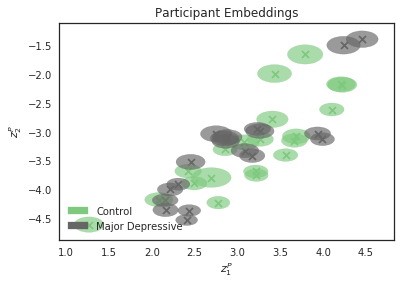

In [26]:
dtfa.scatter_subject_embedding(labeler=condition_labeler, figsize=None)

In [27]:
dtfa.average_reconstruction_error(weighted=False)

06/11/2019 16:24:36 Average reconstruction error (MSE): 5.70859821e+02 +/- 8.68578769e+01
06/11/2019 16:24:36 Average data norm (Euclidean): 7.93378331e+02 +/- 1.40920715e+02
06/11/2019 16:24:36 Percent average reconstruction error: 73.337381 +/- 1.20559644e+01


(array([ 517.48876953,  522.87902832,  543.17663574,  534.25109863,
         636.51037598,  516.9463501 ,  532.84570312,  557.0234375 ,
         534.03015137,  527.46258545,  530.01123047,  533.21844482,
         517.24328613,  528.5446167 ,  545.51251221,  537.93438721,
         586.30316162,  578.11938477,  582.06182861,  588.87042236,
         604.2411499 ,  616.35675049,  589.46850586,  639.31628418,
         599.64727783,  582.5447998 ,  599.06707764,  643.79992676,
         573.18341064,  639.22991943,  582.45880127,  580.55310059,
         543.75585938,  502.99716187,  534.95184326,  557.51751709,
         485.60620117,  522.24591064,  532.6194458 ,  514.74304199,
         569.66558838,  557.70306396,  528.08099365,  545.36560059,
         551.49761963,  513.96820068,  616.55206299,  511.64837646,
         529.1763916 ,  518.07867432,  494.02093506,  513.82177734,
         516.26049805,  499.84899902,  518.89508057,  503.10110474,
         580.30883789,  533.99145508,  531.66882